Copyright 2020-2022 Universidad Complutense de Madrid

This file software has been employed to calibrate optical spectroscopic data from the OSIRIS instrument at GTC (see [Paliya et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...903L...8P/abstract))

Authors: Cristina Cabello (criscabe@ucm.es), Nicolás Cardiel (cardiel@ucm.es) Jesús Gallego (j.gallego@ucm.es)

SPDX-License-Identifier: GPL-3.0+ License-Filename: LICENSE.txt

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
mpl.rcParams['font.family'] = 'serif'

from astropy.io import fits
from astropy.table import Table
import numpy as np
from scipy.interpolate import interp1d

import sys
sys.path.insert(1, '/Users/criscabe/SOFTWARE/boundfit/exec_boundfit')
from exec_boundfit import BoundaryDef
from exec_boundfit import SuperBoundary

# <span style="color:red">Generation of the response curve</span>  

## In this notebook, we proceed with the generation of the response curve for the flux calibration of OSIRIS spectroscopic data.

To carry out the flux calibration of the target spectrum, we observed the spectro-photometric standard star GD153 with OSIRIS 1000B long-slit mode. The reduction of the standard star was done using Python scripts and the REDUCEME software (https://reduceme.readthedocs.io/en/latest/).

The procedure was:
#### -- Bias subtraction
#### -- Flat fielding
#### -- Cosmic rays removal
#### -- Wavelength calibration and C distortion corretion
#### -- Sky subtraction
#### --  S distortion correction
#### -- 1D spectrum extraction
#### -- Atmospheric extinction correction


We load the 1D spectrum of the spectro-photometric standard star GD153 in units of ADUs/s.

In [3]:
with fits.open('99ha_sx.fits') as hdul:
    header = hdul[0].header
    sp = hdul[0].data

naxis1 = header['naxis1']
naxis2 = header['naxis2']


crpix1 = header['crpix1']
crval1 = header['crval1']
cdelt1 = header['cdelt1']

wave = crval1 + (np.arange(naxis1)+1-crpix1)*cdelt1

exptime = header['TIMEXPO']
sp = sp[0, :] / exptime

We plot the observed star spectrum. In addition, we also plot the telluric transmission spectrum which was computed with SkyCalc, a web application based on the Cerro Paranal Advanced Sky Model (https://www.eso.org/observing/etc/doc/skycalc/helpskycalc.html). We make sure that this telluric spectrum matches the wavelength range covered by the star spectrum, and we adjust its height.

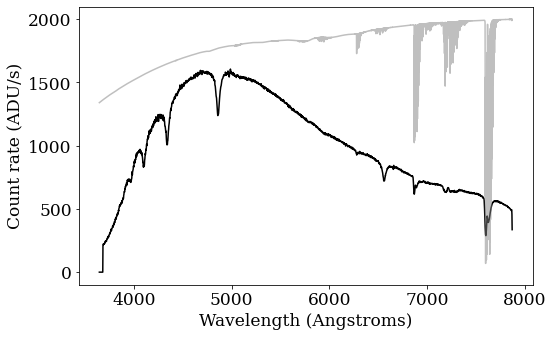

In [11]:
# read telluric transmission
telluric_tabulated = np.genfromtxt("../../skycalc_transmission_R20000.txt")
xtelluric = telluric_tabulated[:,0] * 10  # convert from nm to Angstrom
ytelluric = telluric_tabulated[:,1]

iok = np.argwhere(np.logical_and(xtelluric >= wave.min(), xtelluric <= wave.max()))
xtelluric = xtelluric[iok]
ytelluric = ytelluric[iok]
ytelluric = ytelluric / ytelluric.max() * 2000



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, sp, 'k-')
ax.plot(xtelluric, ytelluric, '-', color='gray', alpha=0.5)
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Count rate (ADU/s)')
fig.tight_layout()

As shown in the figure, the star spectrum is affected by the atmospheric telluric absorptions.

The spectrophotometric standard GD153 is available in CALSPEC (https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/calspec).
We then load this file and have a look at the header info of the tabulated spectrum. 

In [12]:
with fits.open('gd153_stiswfcnic_002.fits') as hdul:
    tbl = hdul[1].data
print(hdul[1].columns)

ColDefs(
    name = 'WAVELENGTH'; format = '1D'; unit = 'ANGSTROMS'; disp = 'G10.4'
    name = 'FLUX'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'STATERROR'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'SYSERROR'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'FWHM'; format = '1E'; unit = 'ANGSTROMS'; disp = 'G6.2'
    name = 'DATAQUAL'; format = '1I'; unit = 'NONE'; disp = 'I2'
    name = 'TOTEXP'; format = '1E'; unit = 'SEC'; disp = 'G10.2'
)


In [13]:
hdul.info()

Filename: gd153_stiswfcnic_002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     132   ()      
  1  SCI           1 BinTableHDU     39   75684R x 7C   [1D, 1E, 1E, 1E, 1E, 1I, 1E]   


In [14]:
stds_table = Table(tbl)
stds_table

WAVELENGTH,FLUX,STATERROR,SYSERROR,FWHM,DATAQUAL,TOTEXP
float64,float32,float32,float32,float32,int16,float32
1140.0206298828125,3.6034e-12,9.137e-14,3.6034e-14,3.6034e-12,0,1237.1
1140.604736,3.472e-12,3.8542e-14,3.472e-14,3.472e-12,1,6184.1
1141.188843,3.3873e-12,3.341e-14,3.3873e-14,3.3873e-12,1,6780.1
1141.772949,3.4418e-12,3.0648e-14,3.4418e-14,3.4418e-12,1,6780.1
1142.357056,3.4559e-12,2.8242e-14,3.4559e-14,3.4559e-12,1,6780.1
1142.941162,3.4157e-12,2.5777e-14,3.4157e-14,3.4157e-12,1,6780.1
1143.525269,3.4479e-12,2.3851e-14,3.4479e-14,3.4479e-12,1,6780.1
1144.109375,3.4292e-12,2.1891e-14,3.4292e-14,3.4292e-12,1,6780.1
1144.693481,3.4208e-12,2.0352e-14,3.4208e-14,3.4208e-12,1,6780.1


Next, we extract the wavelength and the flux of the tabulated spectrum of GD153.

We perform a linear 1D interpolation to obtain the tabulated fluxes for the wavelength values within the wavelength range covered by our observed spectrum.


We compare the observed (blue) and tabulated (dark red) spectra of GD153. The telluric absorptions are marked in gray.

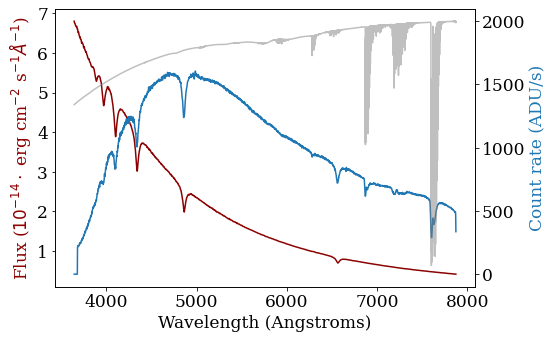

In [17]:
stds_wave = np.array(stds_table['WAVELENGTH'])
stds_flam = np.array(stds_table['FLUX'])

funflam = interp1d(stds_wave, stds_flam, kind='linear')
flam = funflam(wave)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, flam*10**(14), color='darkred')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel(r'Flux ($10^{-14} \cdot$ erg cm$^{-2}$ s$^{-1} \AA^{-1}$)', color='darkred')
ax2 = ax.twinx()
ax2.plot(wave, sp, '-')
ax2.set_ylabel('Count rate (ADU/s)', color='C0')
ax2.plot(xtelluric, ytelluric, '-', color='gray', alpha=0.5)
fig.tight_layout()

We checked that the absorption features present the same broadness in both spectra.
Then, the response curve is computed by dividing the observed spectrum by the tabulated spectrum. 

We plot the observed spectrum (blue) and the derived response curve (black). The telluric absorptions are marked in gray.

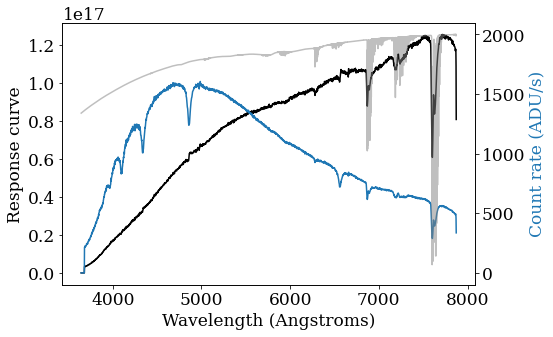

In [18]:
response = sp / flam

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, response, 'k-')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Response curve')
ax2 = ax.twinx()
ax2.plot(wave, sp, '-')
ax2.set_ylabel('Count rate (ADU/s)', color='C0')
ax2.plot(xtelluric, ytelluric, '-', color='gray', alpha=0.5)
fig.tight_layout()

The response curve presents several absorptions which allows us to perform the flux calibration as well as the telluric correction. 

However, we used the package **boundfit** (https://boundfit.readthedocs.io/en/latest/) (see [Cardiel 2009](https://ui.adsabs.harvard.edu/abs/2009MNRAS.396..680C/abstract)) to fit an upper boundary of the stellar continuum and thus derive a telluric correction which takes into account the depth of the absorptions. The correction of this depth is very important when the target and the standard star are observed at different airmasses.

The wavelength range was divided into different subintervals, which were independently fitted. 
In particular, we fitted adaptive splines in different wavelength ranges by changing the positions of the knots in an iterative process.

The _'BoundaryDef'_ function allows us to select the individual regions in order to apply different degrees of freedom to each particular fit according to the variability exhibited by the local continuum. We defined the minimum and maximum wavelength, the number of knots used in the fit, and refined their position.

These individual fits are automatically averaged in the overlapping regions to provide an overall piecewise function thanks to the _'SuperBoundary'_ function.

In [20]:
# We create a list with the individual fits


def list_of_br(itype=0):
    lbr = []
    lbr.append(BoundaryDef(xminfit=3700, xmaxfit=4800, knots=7, crefine='XY'))
    lbr.append(BoundaryDef(xminfit=4900, xmaxfit=6260, knots=7, crefine='XY'))
    if itype == 1:
        lbr.append(BoundaryDef(xminfit=6260, xmaxfit=6400, knots=0)) # knots = 0 will return the original data
    lbr.append(BoundaryDef(xminfit=6400, xmaxfit=6525, knots=2, crefine='XY'))
    if itype == 0:
        lbr.append(BoundaryDef(xminfit=6730, xmaxfit=7750, knots=5, rigidity=0.02, crefine='XY'))
    else:
        lbr.append(BoundaryDef(xminfit=6730, xmaxfit=7750, knots=0)) # knots = 0 will return the original data
    lbr.append(BoundaryDef(xminfit=7750, xmaxfit=7867, knots=3, crefine='XY'))
    return lbr

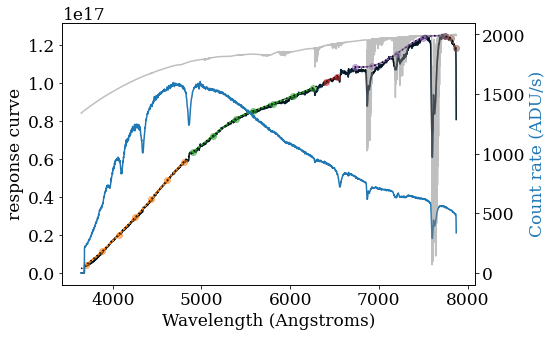

In [22]:
xfactor = 1E-4               # Normalization factor in the X axis
yfactor = 1/response.max()   # Normalization factor in the Y axis
medfiltwidth=11              # Width of the median filter to smooth the noise


# boundfit allows fitting the continuum without being affected by telluric absorptions 
# continuum1 corresponds with the upper boundary of the stellar continuum.


continuum1 = SuperBoundary(
    xfit=wave,
    yfit=response,
    listboundregions=list_of_br(0),
    xfactor=xfactor,
    yfactor=yfactor,
    medfiltwidth=medfiltwidth
)

# In this case, continuum2 corresponds with the response curve because the number of knots was set to zero


continuum2 = SuperBoundary(
    xfit=wave,
    yfit=response,
    listboundregions=list_of_br(1),
    xfactor=xfactor,
    yfactor=yfactor,
    medfiltwidth=medfiltwidth
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, response, 'k-')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Response curve')
continuum1.plot(ax=ax, xlabel='Wavelength (Angstroms)', ylabel='response curve')
ax.get_legend().remove()
ax2 = ax.twinx()
ax2.plot(wave, sp, '-')
ax2.set_ylabel('Count rate (ADU/s)', color='C0')
ax2.plot(xtelluric, ytelluric, '-', color='GRAY', alpha=0.5)
fig.tight_layout()

In [23]:
# replace additinal boundary regions by actual curve
for i in range(len(wave)):
    if 5835 <= wave[i] <= 6035:
        continuum2.yboundary[i] = response[i]

The fit to the stellar continuum corresponds with the variable **continuum1** (dotted line with different colors depending on the spectral region).

The response curve is **continuum2** (black line).


The normalized telluric absorption spectrum is computed as **continuum2** / **continuum1** (green line).

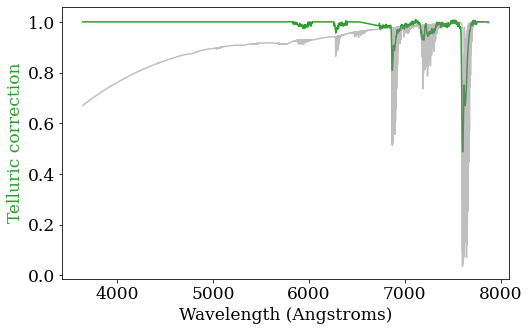

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, continuum2.yboundary/continuum1.yboundary, 'k-', color='C2')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Telluric correction', color='C2')
ax.plot(xtelluric, ytelluric/2000, '-', color='gray', alpha=0.5)
plt.show()

Finally, we save the txt file with the wavelength, the response curve, and the continuum boundaries derived with **boundfit**. 

In [16]:
with open('response.txt', 'tw') as f:
    for x, y1, y2, y3 in zip(wave, response, continuum1.yboundary, continuum2.yboundary):
        f.write('{:9.4f}  {:e}  {:e}  {:e}\n'.format(x, y1, y2, y3))